<a href="https://colab.research.google.com/github/jorobledo/Autoencoder_convolucional/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import numpy as np
from torchsummary import summary 

In [ ]:
#datos
mnist_train = datasets.MNIST('data',train=True,download=True,transform=transforms.ToTensor())
len(list(mnist_train))


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


60000

In [ ]:
mnist_test = datasets.MNIST('data',train=False,download=True,transform=transforms.ToTensor())
# mnist_test = list(mnist_test)[:5000]
len(list(mnist_test))

10000

# Ejemplo de capa convolucional

## Reducción de dimensión

torch.Size([1, 8, 14, 14])


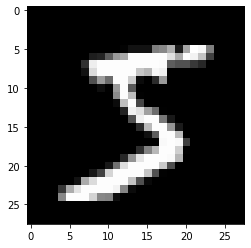

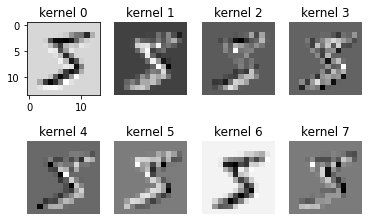

In [ ]:
# Prueba para reducción de dimensión con capa conv.
x = mnist_train[0][0][None,:]
conv1 =  nn.Conv2d(in_channels=1,out_channels=8,kernel_size=3,stride=2,padding=1) #salida 14x14
# # x = torch.randn(64, 32, 7, 7)
x2 = conv1(x)
print(x2.shape)
plt.imshow(x[0].squeeze(0).detach().numpy(),cmap='gray')
plt.show()
for i in range(x2.shape[1]):  
  plt.subplot(2,4,i+1)
  plt.imshow(x2.squeeze(0).detach().numpy()[i],cmap='gray')
  if i!=0:
    plt.axis('off')
  plt.title(f'kernel {i}')
plt.show()
# convT1 = nn.ConvTranspose2d(in_channels=64,
#                            out_channels=32,
#                            kernel_size=3,
#                            stride=2,
#                           #  output_padding=1,
#                           #  padding=2
#                           )
# convT1(x2).shape

## conv + max pooling

torch.Size([1, 8, 14, 14])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


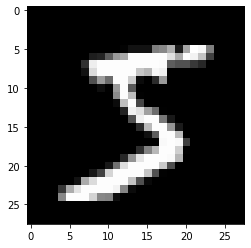

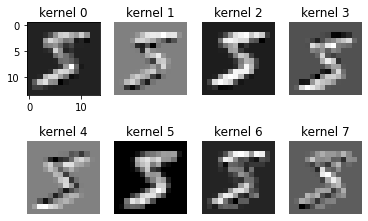

In [ ]:
# Prueba para ver tamaño
x = mnist_train[0][0][None,:]
conv1 =  nn.Conv2d(in_channels=1,out_channels=8,kernel_size=3,stride=1,padding=1) #salida 14x14
maxpool = nn.MaxPool2d(2,2)
# # x = torch.randn(64, 32, 7, 7)
x2 = conv1(x)
x2 = maxpool(x2)
print(x2.shape)
plt.imshow(x[0].squeeze(0).detach().numpy(),cmap='gray')
plt.show()
for i in range(x2.shape[1]):  
  plt.subplot(2,4,i+1)
  plt.imshow(x2.squeeze(0).detach().numpy()[i],cmap='gray')
  if i!=0:
    plt.axis('off')
  plt.title(f'kernel {i}')
plt.show()
# convT1 = nn.ConvTranspose2d(in_channels=64,
#                            out_channels=32,
#                            kernel_size=3,
#                            stride=2,
#                           #  output_padding=1,
#                           #  padding=2
#                           )
# convT1(x2).shape

# Funciones

## Función que define el entrenamiento

In [ ]:
def train(model, num_epochs=5, batch_size=100, learning_rate=1e-3):
  print(summary(model,(1,28,28)))
  torch.manual_seed(42)
  criterion = nn.MSELoss() # mean square error loss
  optimizer = torch.optim.Adam(model.parameters(),
                                lr=learning_rate, 
                                weight_decay=1e-5) # <--

  train_loader = torch.utils.data.DataLoader(mnist_train, 
                                            batch_size=batch_size, 
                                            shuffle=True)

  test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size)

  outputs = []
  init_outputs = []
  avg_loss = 0
  for epoch in range(num_epochs):
    for i,data in enumerate(train_loader):
        img, _ = data
        recon = model.forward(img)
        loss = criterion(recon, img)
        if (epoch==0) and (i%10==0):
          init_outputs.append((img, recon,loss))
          # print('Epoch:{}, Loss:{:.4f}, test loss:{}'.format(epoch, float(loss),'No test'))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        avg_loss +=float(loss)
    avg_loss/=len(train_loader)

    #test this stage:
    avg_loss_test = 0
    for datas in test_loader:
      im, _ = datas
      test_recon = model(im)
      loss_test = criterion(test_recon, im)
      avg_loss_test +=float(loss_test)
    avg_loss_test/=len(test_loader)

    print('Epoch:{}, Loss:{:.4f}, test loss:{:.4f}'.format(epoch+1, float(avg_loss),float(avg_loss_test)))
    outputs.append((epoch+1, img, recon,loss,loss_test))
    # outputs.append((epoch, float(loss), float(loss_test)))
  return outputs,init_outputs

## Funcion que grafica los resultados de los primeros minibatches

In [ ]:
def graph_mini(init_outputs,nview=20):
  for k in range(0, np.shape(init_outputs)[0]):
    if (k%nview==0) and (k<nview*100):
      plt.figure(figsize=(9, 2))
      imgs = init_outputs[k][0].detach().numpy()
      recon = init_outputs[k][1].detach().numpy()
      print(f'minibatch: {k}')
      for i, item in enumerate(imgs):
          if i >= 9: break
          plt.subplot(2, 9, i+1)
          plt.axis('off')
          plt.imshow(item[0],cmap='gray')
          
      for i, item in enumerate(recon):
          if i >= 9: break
          plt.subplot(2, 9, 9+i+1)
          plt.axis('off')
          plt.imshow(item[0],cmap='gray')
      plt.show()

## Función que explora el espacio embebido

In [ ]:
def exploreEmbedded(model,imList=[1,100,512,1980,4500],mnist_test=mnist_test):
  for i in imList:
    im = mnist_test[i][0]

    case = model.forward(im[None,:])
    embed = model.encoder(im[None,:])

    plt.subplot(4,6,7)
    plt.title('original')
    plt.imshow(im.detach().numpy().squeeze(0),cmap='gray')
    plt.axis('off')

    j = 0
    for i in range(1,4*6+1):
      if i not in [1,6,7,12,13,18,19,24]:
        plt.subplot(4,6,i)
        plt.imshow(embed[0,j].detach().numpy(),cmap='gray')
        plt.tick_params(
                axis='both',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                left=False,
                labelleft=False,
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off
        j+=1
    plt.subplot(4,6,12)
    plt.title('Recon')
    plt.axis('off')
    plt.imshow(case.detach().numpy()[0].squeeze(0),cmap='gray')
    plt.show()

## Función que interpola

In [ ]:
def interpolate(model,im1,im2,mnist_test=mnist_test):
  prueba = torch.stack([mnist_test[im1][0],mnist_test[im2][0]])

  # Generamos la codifiación en el espacio latente.
  embedding = model.encoder(prueba)

  #Seleccionamos las dos imagenes que vamos a interpolar
  e1 = embedding[0]
  e2 = embedding[1]

  # Hacemos combinación lineal de las imagenes para crear otros números similares por ejemplo.
  embedding_values = []
  for i in range(0,10):
    e = e2 * i/10 + e1 * (10-i)/10
    embedding_values.append(e)
  embedding_values = torch.stack(embedding_values)

  recons = model.decoder(embedding_values)

  #graficamos la interpolacion
  plt.figure(figsize=(10, 2))
  for i, recon in enumerate(recons.detach().numpy()):
    plt.subplot(2,10,i+11)
    plt.axis('off')
    plt.imshow(recon[0],cmap='gray')
  plt.subplot(2,10,1)
  plt.imshow(mnist_test[im1][0].squeeze(0),cmap='gray')
  plt.axis('off')
  plt.subplot(2,10,10)
  plt.imshow(mnist_test[im2][0].squeeze(0),cmap='gray')
  plt.axis('off')
  plt.show()

# Red de tres capas

## Modelo

In [ ]:
#tres capas
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=8,kernel_size=3,stride=2,padding=1), #salida 14x14
        nn.ReLU(),
        nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,stride=2,padding=1), #salida 7x7 
        nn.ReLU(),
        nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=2), #salida 3x3
        # nn.ReLU()
    )

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(in_channels=32,out_channels=16,kernel_size=3,stride=2),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=16,out_channels=8,kernel_size=3,stride=2,padding=1,output_padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=8,out_channels=1,kernel_size=3,stride=2,padding=1,output_padding=1),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

model1 = Autoencoder()
print(summary(model1,(1,28,28)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 14, 14]              80
              ReLU-2            [-1, 8, 14, 14]               0
            Conv2d-3             [-1, 16, 7, 7]           1,168
              ReLU-4             [-1, 16, 7, 7]               0
            Conv2d-5             [-1, 32, 3, 3]           4,640
   ConvTranspose2d-6             [-1, 16, 7, 7]           4,624
              ReLU-7             [-1, 16, 7, 7]               0
   ConvTranspose2d-8            [-1, 8, 14, 14]           1,160
              ReLU-9            [-1, 8, 14, 14]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]              73
          Sigmoid-11            [-1, 1, 28, 28]               0
Total params: 11,745
Trainable params: 11,745
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

## Entrenamiento

In [ ]:
%%time
#red de dos capas hasta 3x3 1
max_epochs = 20
outputs, init_outputs = train(model1,num_epochs=max_epochs,batch_size=64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 14, 14]              80
              ReLU-2            [-1, 8, 14, 14]               0
            Conv2d-3             [-1, 16, 7, 7]           1,168
              ReLU-4             [-1, 16, 7, 7]               0
            Conv2d-5             [-1, 32, 3, 3]           4,640
   ConvTranspose2d-6             [-1, 16, 7, 7]           4,624
              ReLU-7             [-1, 16, 7, 7]               0
   ConvTranspose2d-8            [-1, 8, 14, 14]           1,160
              ReLU-9            [-1, 8, 14, 14]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]              73
          Sigmoid-11            [-1, 1, 28, 28]               0
Total params: 11,745
Trainable params: 11,745
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

## Grafico

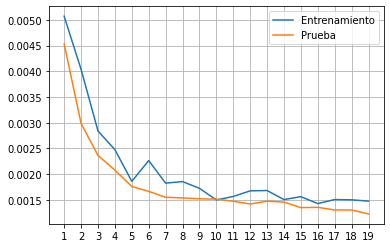

In [ ]:
loss = [i[3] for i in outputs]
loss_test = [i[4] for i in outputs]
x = [i for i in range(1,20)]
plt.plot(x,loss[1:],label='Entrenamiento')
plt.plot(x,loss_test[1:],label='Prueba')
plt.legend()
plt.grid()
plt.xticks(x)
plt.show()

# red de dos capas

## Modelo

In [ ]:
#menor cantidad de parametros
#dos capas a 3x3
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=8,kernel_size=3,stride=3), #salida 9x9
        nn.ReLU(),
        nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,stride=3), #salida 3x3
        # nn.ReLU()
    )

    self.decoder = nn.Sequential(
        # nn.ConvTranspose2d(in_channels=64,out_channels=32,kernel_size=3,stride=2),
        # nn.ReLU(),
        nn.ConvTranspose2d(in_channels=16,
                           out_channels=8,
                           kernel_size=3,
                           stride=3,
                          #  output_padding=1,
                          #  padding=2
                          ),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=8,
                           out_channels=1,
                           kernel_size=3,
                           stride=3,
                           output_padding=1,
                          #  padding=2
                          ),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

model2 = Autoencoder()
print(summary(model2,(1,28,28)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1              [-1, 8, 9, 9]              80
              ReLU-2              [-1, 8, 9, 9]               0
            Conv2d-3             [-1, 16, 3, 3]           1,168
   ConvTranspose2d-4              [-1, 8, 9, 9]           1,160
              ReLU-5              [-1, 8, 9, 9]               0
   ConvTranspose2d-6            [-1, 1, 28, 28]              73
           Sigmoid-7            [-1, 1, 28, 28]               0
Total params: 2,481
Trainable params: 2,481
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.01
Estimated Total Size (MB): 0.05
----------------------------------------------------------------
None


## Entrenamiento

In [ ]:
%%time
#red de dos capas hasta 3x3 1
max_epochs = 20
outputs2, init_outputs2 = train(model2,num_epochs=max_epochs,batch_size=64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1              [-1, 8, 9, 9]              80
              ReLU-2              [-1, 8, 9, 9]               0
            Conv2d-3             [-1, 16, 3, 3]           1,168
   ConvTranspose2d-4              [-1, 8, 9, 9]           1,160
              ReLU-5              [-1, 8, 9, 9]               0
   ConvTranspose2d-6            [-1, 1, 28, 28]              73
           Sigmoid-7            [-1, 1, 28, 28]               0
Total params: 2,481
Trainable params: 2,481
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.01
Estimated Total Size (MB): 0.05
----------------------------------------------------------------
None
Epoch:1, Loss:0.0493, test loss:0.0202
Epoch:2, Loss:0.0152, test loss:0.0115
Epoch:3, Loss:0.0101, test 

## Gráfico

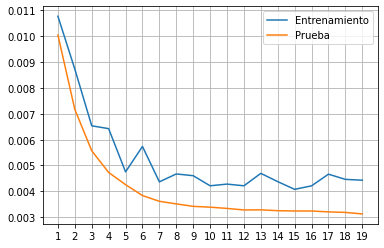

In [ ]:
loss2 = [i[3] for i in outputs2]
loss_test2 = [i[4] for i in outputs2]
x = [i for i in range(1,20)]
plt.plot(x,loss2[1:],label='Entrenamiento')
plt.plot(x,loss_test2[1:],label='Prueba')
plt.legend()
plt.grid()
plt.xticks(x)
plt.show()

minibatch: 0


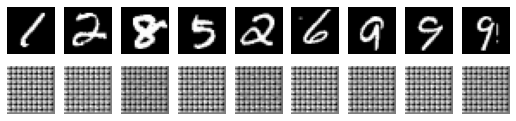

minibatch: 20


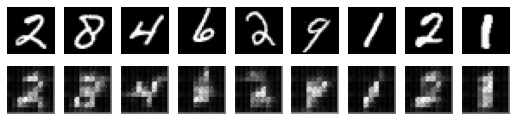

minibatch: 40


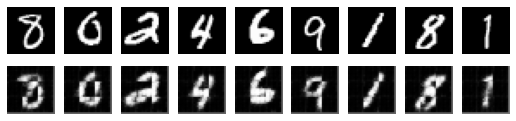

minibatch: 60


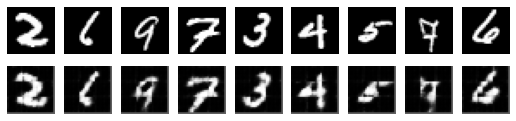

minibatch: 80


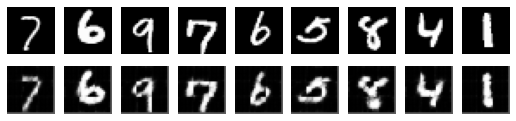

In [ ]:
graph_mini(init_outputs2)

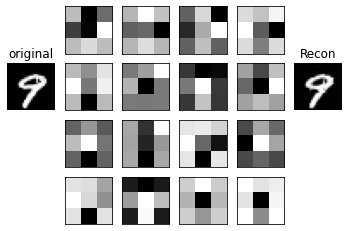

In [ ]:
exploreEmbedded(model2,imList=[9])

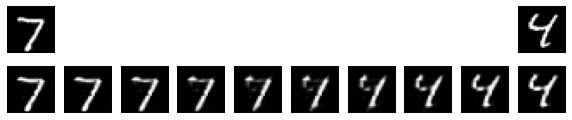

In [ ]:
interpolate(model2,0,6)

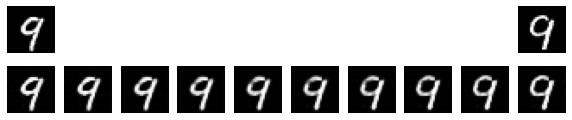

In [ ]:
interpolate(model2,12,16)

# Modelo con dos capas pero con maxpool

##Modelo

In [ ]:
#dos capas
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=8,kernel_size=3,padding=1), #salida 14x14
        # nn.Conv2d(in_channels=1,out_channels=8,kernel_size=3,stride=1,padding=1), #salida 9x9
        nn.ReLU(),
        nn.MaxPool2d(3,3),
        nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,padding=1), #salida 7x7 
        nn.MaxPool2d(3,3) #salida 3,3
        # nn.ReLU(),
        # nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=2) #salida 7x7
    )

    self.decoder = nn.Sequential(
        # nn.ConvTranspose2d(in_channels=64,out_channels=32,kernel_size=3,stride=2),
        # nn.ReLU(),
        nn.ConvTranspose2d(in_channels=16,
                           out_channels=8,
                           kernel_size=3,
                           stride=3,
                          #  output_padding=1,
                          #  padding=2
                          ),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=8,
                           out_channels=1,
                           kernel_size=3,
                           stride=3,
                           output_padding=1,
                          #  padding=2
                          ),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x


model3 = Autoencoder()
print(summary(model3,(1,28,28)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
              ReLU-2            [-1, 8, 28, 28]               0
         MaxPool2d-3              [-1, 8, 9, 9]               0
            Conv2d-4             [-1, 16, 9, 9]           1,168
         MaxPool2d-5             [-1, 16, 3, 3]               0
   ConvTranspose2d-6              [-1, 8, 9, 9]           1,160
              ReLU-7              [-1, 8, 9, 9]               0
   ConvTranspose2d-8            [-1, 1, 28, 28]              73
           Sigmoid-9            [-1, 1, 28, 28]               0
Total params: 2,481
Trainable params: 2,481
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.13
Params size (MB): 0.01
Estimated Total Size (MB): 0.15
-----------------------------------------------

## Entrenamiento

In [ ]:
%%time
#red de dos capas hasta 3x3 1
max_epochs = 20
outputs3, init_outputs3 = train(model3,num_epochs=max_epochs,batch_size=64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
              ReLU-2            [-1, 8, 28, 28]               0
         MaxPool2d-3              [-1, 8, 9, 9]               0
            Conv2d-4             [-1, 16, 9, 9]           1,168
         MaxPool2d-5             [-1, 16, 3, 3]               0
   ConvTranspose2d-6              [-1, 8, 9, 9]           1,160
              ReLU-7              [-1, 8, 9, 9]               0
   ConvTranspose2d-8            [-1, 1, 28, 28]              73
           Sigmoid-9            [-1, 1, 28, 28]               0
Total params: 2,481
Trainable params: 2,481
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.13
Params size (MB): 0.01
Estimated Total Size (MB): 0.15
-----------------------------------------------

## Gráfico

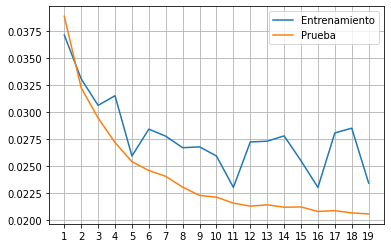

In [ ]:
loss3 = [i[3] for i in outputs3]
loss_test3 = [i[4] for i in outputs3]
x = [i for i in range(1,20)]
plt.plot(x,loss3[1:],label='Entrenamiento')
plt.plot(x,loss_test3[1:],label='Prueba')
plt.legend()
plt.grid()
plt.xticks(x)
plt.show()

# Comparación

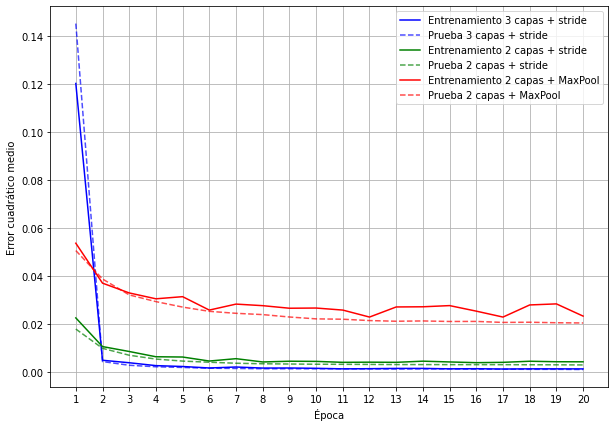

In [ ]:
plt.figure(figsize=(10,7))
x = [i for i in range(1,21)]
plt.plot(x,loss,label='Entrenamiento 3 capas + stride',c='blue')
plt.plot(x,loss_test,'--',label='Prueba 3 capas + stride',c='blue',alpha=0.7)

plt.plot(x,loss2,label='Entrenamiento 2 capas + stride',c='green')
plt.plot(x,loss_test2,'--',label='Prueba 2 capas + stride',c='green',alpha=0.7)

plt.plot(x,loss3,label='Entrenamiento 2 capas + MaxPool',c='red')
plt.plot(x,loss_test3,'--',label='Prueba 2 capas + MaxPool',c='red',alpha=0.7)

plt.legend()
plt.grid()
plt.xticks(x)
plt.xlabel('Época')
plt.ylabel('Error cuadrático medio')
plt.show()